# Bot Activity Analysis
---

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

In [2]:
bots = pd.read_csv('bot_tests_BIG.csv')

In [3]:
bots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 25 columns):
id                       int64
bot_score                int64
uuid                     object
phantom_ua               int64
phantom_properties       int64
phantom_etsl             int64
phantom_language         int64
phantom_websocket        int64
mq_screen                int64
phantom_overflow         int64
phantom_window_height    int64
headchr_ua               int64
webdriver                int64
headchr_chrome_obj       int64
headchr_permissions      int64
headchr_plugins          int64
headchr_iframe           int64
chr_debug_tools          int64
selenium_driver          int64
chr_battery              int64
chr_memory               int64
transparent_pixel        int64
sequentum                int64
video_codecs             int64
time_record              object
dtypes: int64(23), object(2)
memory usage: 2.0+ GB


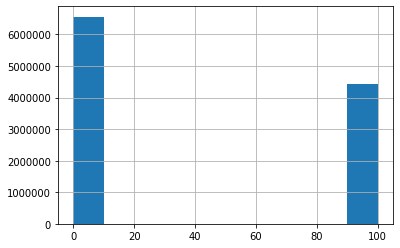

In [5]:
bots['bot_score'].hist()
# The scores here are:
    # 0 for bot
    # 90-99.99 for potential for bot 
    # 100 for human


In [6]:
bots['human'] = bots['bot_score']==100
# True is human / False is bot

### Removing unnecessary variables and preventing overfitting. 

In [7]:
bots_analysis = bots.drop(['time_record','uuid','id','bot_score'],axis=1)
bots_analysis.info()
bots_analysis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 22 columns):
phantom_ua               int64
phantom_properties       int64
phantom_etsl             int64
phantom_language         int64
phantom_websocket        int64
mq_screen                int64
phantom_overflow         int64
phantom_window_height    int64
headchr_ua               int64
webdriver                int64
headchr_chrome_obj       int64
headchr_permissions      int64
headchr_plugins          int64
headchr_iframe           int64
chr_debug_tools          int64
selenium_driver          int64
chr_battery              int64
chr_memory               int64
transparent_pixel        int64
sequentum                int64
video_codecs             int64
human                    bool
dtypes: bool(1), int64(21)
memory usage: 1.7 GB


,phantom_ua,phantom_properties,phantom_etsl,phantom_language,phantom_websocket,mq_screen,phantom_overflow,phantom_window_height,headchr_ua,webdriver,...,headchr_plugins,headchr_iframe,chr_debug_tools,selenium_driver,chr_battery,chr_memory,transparent_pixel,sequentum,video_codecs,human
0,2,2,2,2,2,2,2,2,2,2,...,1,0,2,2,2,0,2,2,2,False
1,2,2,2,2,2,2,2,2,2,0,...,2,2,2,2,2,2,2,2,1,False
2,2,2,2,2,2,0,2,0,2,2,...,2,2,2,2,2,2,2,2,2,False
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,True
4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,True


# I am curious to see only how the decision tree handles the data. Rather than explore through EDA, I will only be implementing the algorithm.

In [8]:
bots_analysis['human'].value_counts() 

False    7672792
True     3327208
Name: human, dtype: int64

### There is a huge set of this instances being bots. The reason for this analysis is based on understanding if our algorithm is incorreclty classifying mobile user traffic as bot traffic. The large proportion of bot activity may indicate this to be true, but we will not explore that here.

In [17]:
X=bots_analysis.drop('human',axis=1)
y=bots_analysis['human']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5,random_state=47)

Index(['phantom_ua', 'phantom_properties', 'phantom_etsl', 'phantom_language',
       'phantom_websocket', 'mq_screen', 'phantom_overflow',
       'phantom_window_height', 'headchr_ua', 'webdriver',
       'headchr_chrome_obj', 'headchr_permissions', 'headchr_plugins',
       'headchr_iframe', 'chr_debug_tools', 'selenium_driver', 'chr_battery',
       'chr_memory', 'transparent_pixel', 'sequentum', 'video_codecs'],
      dtype='object')

In [19]:
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
pred=dtree.predict(X_test)

In [20]:
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

[[3836587       0]
 [      0 1663413]]


              precision    recall  f1-score   support

       False       1.00      1.00      1.00   3836587
        True       1.00      1.00      1.00   1663413

    accuracy                           1.00   5500000
   macro avg       1.00      1.00      1.00   5500000
weighted avg       1.00      1.00      1.00   5500000



# These results appear to be overfitting the model. While this would be concerning if I were hoping to have this model move to production, I am only curious about what variables the model is using most to classify traffic. 

In [27]:
features = list(bots_analysis.columns[:-1])
features

['phantom_ua',
 'phantom_properties',
 'phantom_etsl',
 'phantom_language',
 'phantom_websocket',
 'mq_screen',
 'phantom_overflow',
 'phantom_window_height',
 'headchr_ua',
 'webdriver',
 'headchr_chrome_obj',
 'headchr_permissions',
 'headchr_plugins',
 'headchr_iframe',
 'chr_debug_tools',
 'selenium_driver',
 'chr_battery',
 'chr_memory',
 'transparent_pixel',
 'sequentum',
 'video_codecs']

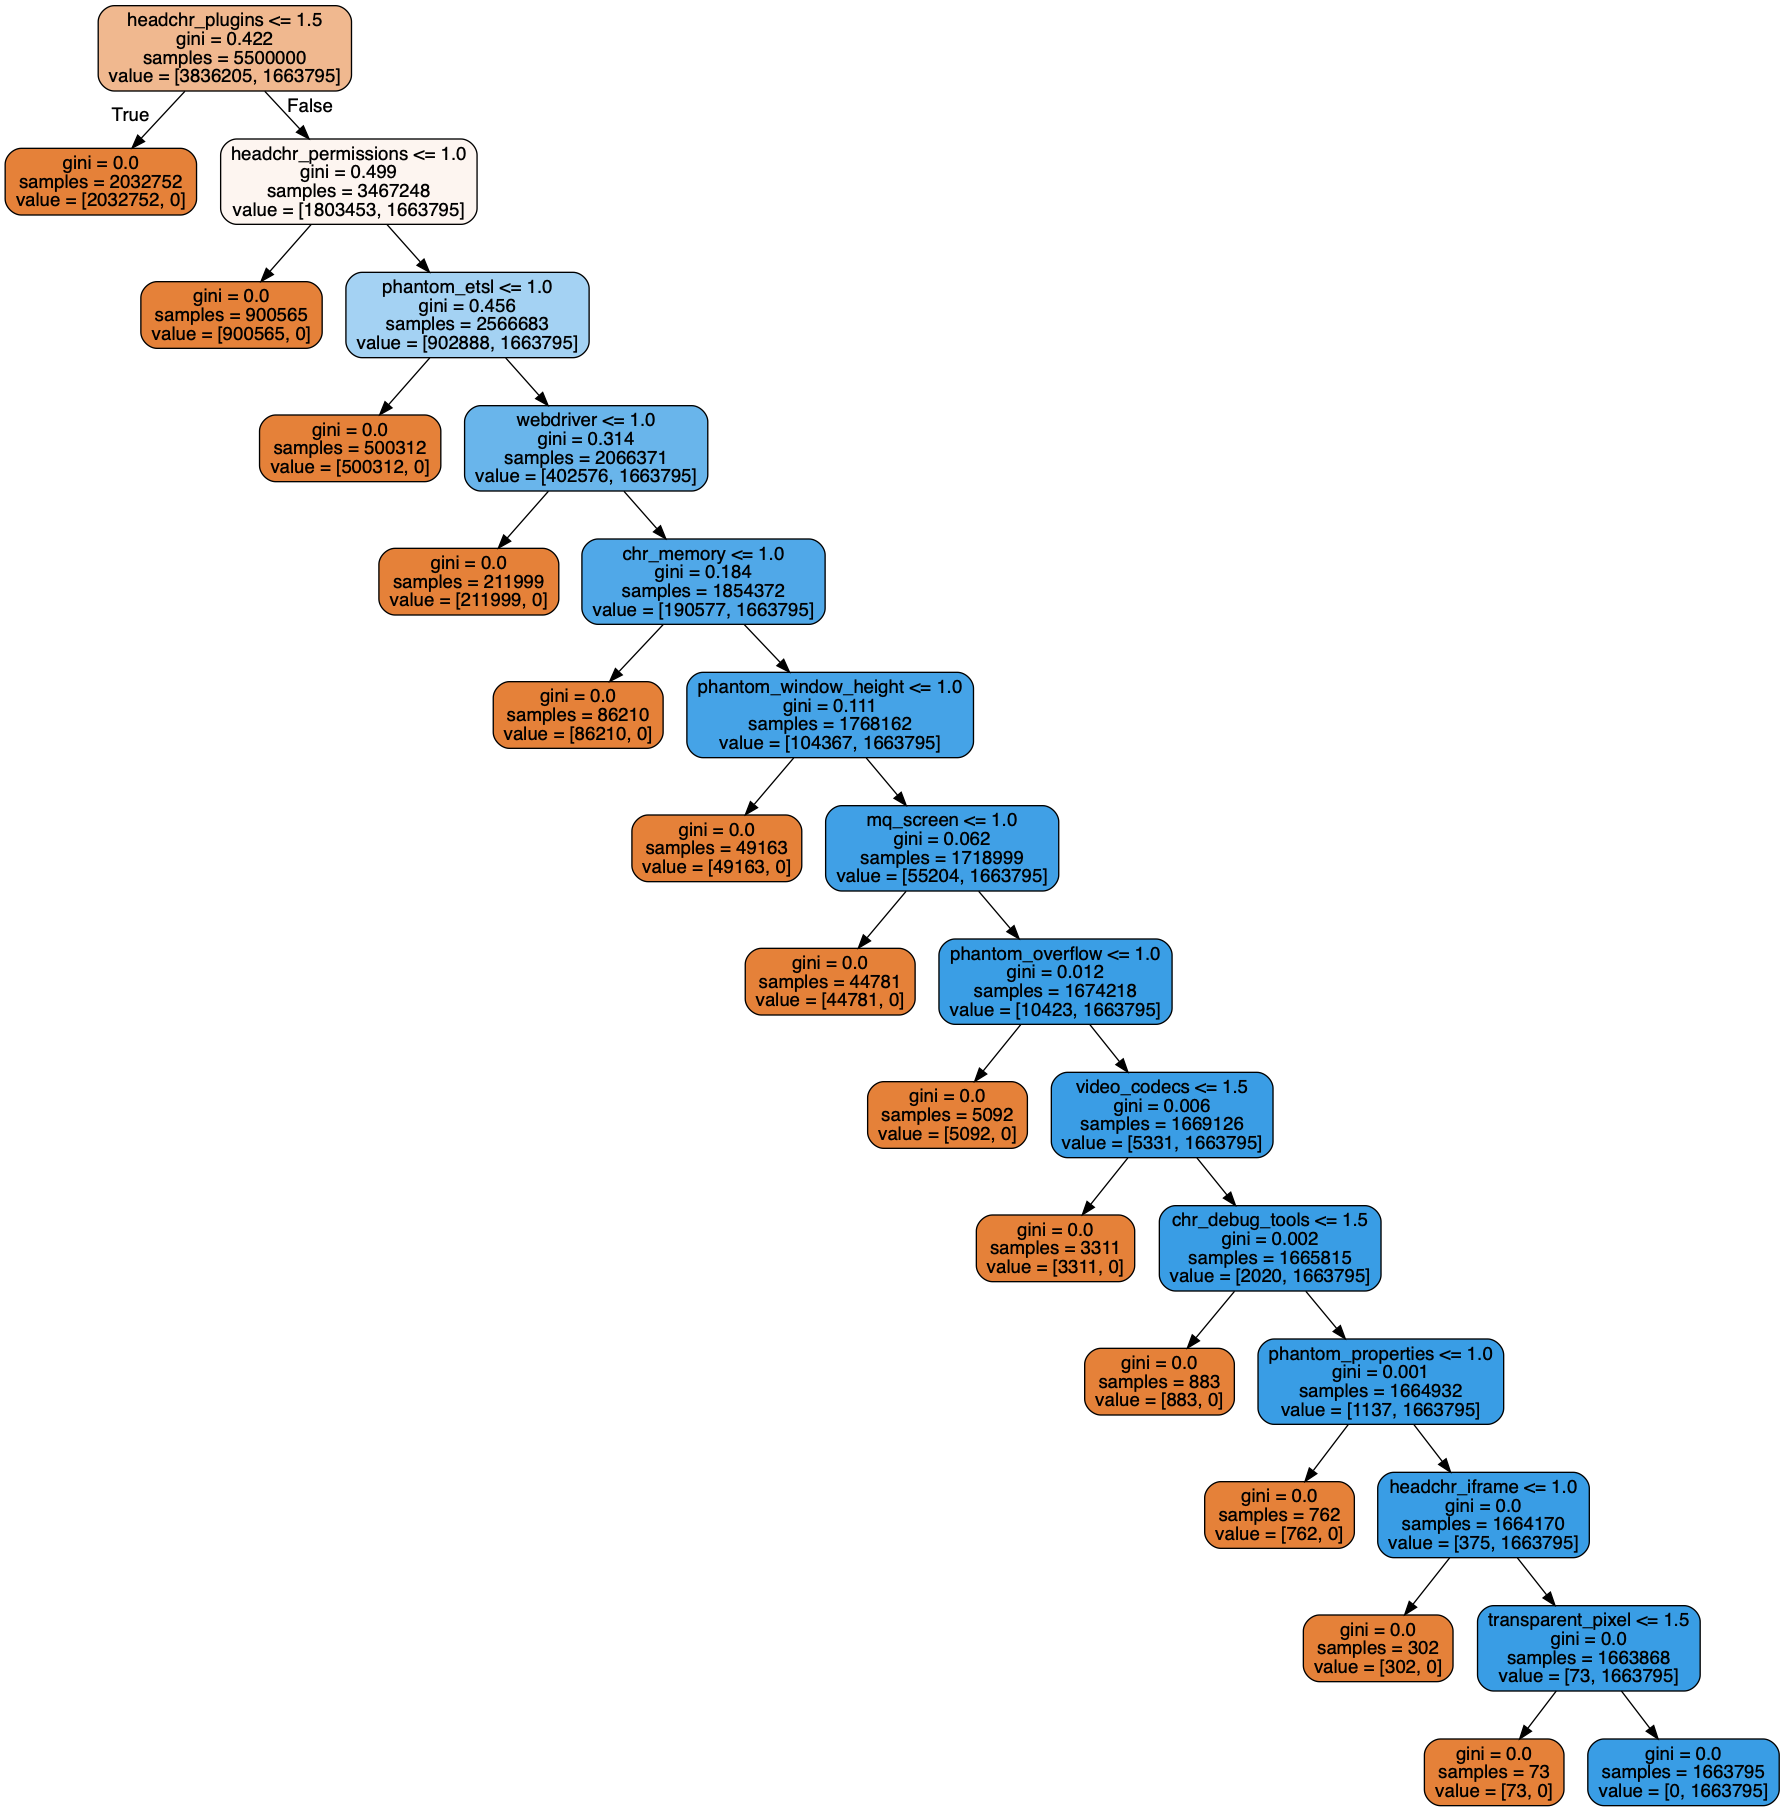

In [29]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

### From what is shown here, the most utilized variable is `headchr_plugins`. This variable was of interest before this analysis and now becomes the main contributor to understanding our classifier's activities. This variable is related to  the plugins in any given `user_agent_string` analyzed by our algorithm. Without going to deep into this, the `user_agent_string` holds all information related to the attributes of an individual's hardware and software allowing them to cause an impression on our ads. What we know currently, is that mobile traffic has different plugins than desktop traffic. With this new information we will be able to continue our investigation. 